In [126]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable, grad
# import pyredner
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torch.nn as nn

from PIL import Image
import numpy as np
import random

import sys
sys.path.insert(0,'/om5/user/smadan/redner/')

import pyredner

print(pyredner.__file__)

/om5/user/smadan/redner/pyredner/__init__.py


# Rendering on ShapeNet Object

In [117]:
##### Randomization Functions ######

RADIUS_MIN = 8.0
RADIUS_MAX = 14.0
MIN_NUM_LIGHTS = 1
MAX_NUM_LIGHTS = 4

RADIUS_MIN_CAM = 2.0
RADIUS_MAX_CAM = 5.0

def generate_uniform_on_sphere(num_points, radius):
    points = []
    for i in range(num_points):
        X = np.random.normal()
        Y = np.random.normal()
        Z = np.random.normal()

        vector = np.array([X,Y,Z])
        point = list(radius*vector/np.linalg.norm(vector))
        points.append(point)
    return points
def get_cam_position(radius_min, radius_max):
    random_radius = random.uniform(radius_min, radius_max)
#     random_radius = 5.0
    cam_point = generate_uniform_on_sphere(1, random_radius)[0]
    cam_point = torch.tensor(cam_point).float()

    return cam_point

In [118]:
# scene_cam_pos =  torch.tensor([val, val, val])
scene_cam_pos = get_cam_position(RADIUS_MIN_CAM, RADIUS_MAX_CAM)
scene_light_pos = torch.tensor([.5, .5, -0.5])
scene_light_intensity = torch.tensor([5000.0, 5000.0, 5000.0])

In [135]:
len(scene_cube.area_lights)

1

In [120]:
## Setting up Renderer
pyredner.render_pytorch.print_timing = True
model_file = '/om5/user/smadan/ShapeNetCore.v2//02691156/18d55087d052ecc86b7bd17e458d0dcb/models/model_normalized.obj'
# model_file = '/om5/user/smadan/ShapeNetCore.v2/02691156/b089abdb33c39321afd477f714c68df9/models/model_normalized.obj'
# obj_model = pyredner.load_obj('assets/cube/cube.obj', return_objects=True)
obj_model_all = pyredner.load_obj(model_file, return_objects=True)
obj_model = [i for i in obj_model_all if len(i.vertices)>0]
# cube = cube_object_list[0]
m = pyredner.Material(diffuse_reflectance = torch.tensor((0.8, 0.8, 0.8), device = pyredner.get_device()))
for part in obj_model:
    part.material = m

scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224))
scene_cam.position = scene_cam_pos
scene_light = pyredner.generate_quad_light(position = scene_light_pos,
                                     look_at = torch.zeros(3),
                                     size = torch.tensor([0.1, 0.1]),
                                     intensity = scene_light_intensity,
                                     directly_visible = False)



all_objects = obj_model + [scene_light]
# scene_light.light_intensity = li
scene_cube = pyredner.Scene(objects = all_objects, camera = scene_cam)
rendered_channels = [pyredner.channels.shape_id]
img_mask = pyredner.render_generic(scene_cube,channels = rendered_channels)
img_cube = pyredner.render_pathtracing(scene_cube,num_samples=256)
im = torch.pow(img_cube.data, 1.0/2.2).cpu()
im = im*255/torch.max(im)
image = Image.fromarray(im.numpy().astype('uint8'))

Scene construction, time: 0.71290 s
Forward pass, time: 0.10983 s
Scene construction, time: 0.63543 s
Forward pass, time: 0.97070 s


In [130]:
dir(scene_cube)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'area_lights',
 'camera',
 'envmap',
 'load_state_dict',
 'materials',
 'shapes',
 'state_dict']

In [ ]:
img = pyredner.render_generic(scene,channels = rendered_channels)
shape_id_arr_ = np.array(img.detach().cpu())[:,:,0]
total_objects = np.max(shape_id_arr_)
non_light_objects = total_objects - num_lights
shape_id_arr = np.logical_and(shape_id_arr_ > 0, shape_id_arr_ <= non_light_objects)

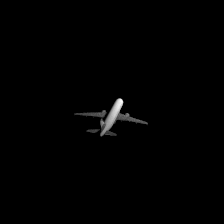

In [121]:
image

In [122]:
img_mask = img_mask.detach().cpu()[:,:,0]

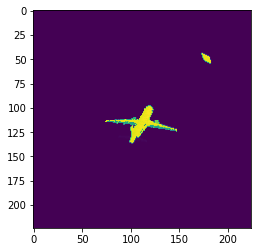

In [123]:
plt.imshow(img_mask)

In [124]:
torch.sum(img_mask)

tensor(209876.8906)

In [97]:
torch.max(img_mask)

tensor(311.)

In [82]:
np.unique(img_mask < 310)

array([False,  True])

In [83]:
# torch.sum(img_mask.detach().cpu() > 0)

# On To other ShapeNet Objects

In [74]:
cam_pos =  torch.tensor([1.0, 1.0, 1.0])
light_pos = torch.tensor([.5, .5, -0.5])
light_intensity = torch.tensor([5000.0, 5000.0, 5000.0])

In [75]:
NUM_LIGHTS = 2

In [76]:
def get_light_positions(pos, num_lights):
    all_combinations = [[1,1,1],[-1,1,1],[1,-1,1],[1,1,-1],[1,-1,-1],[-1,1,-1],[-1,-1,1],[-1,-1,-1]]
    x,y,z = pos[0],pos[1],pos[2]
    
    chosen_combs = random.sample(all_combinations, num_lights)
    
    new_light_positions = [pos]
    for comb in chosen_combs:
        new_light_positions.append(torch.tensor([x*comb[0], y*comb[1], z*comb[2]]))
    return new_light_positions

def render_shapenet_obj(obj_path, camera_position, light_position, light_intensity, show_lights = False):
    obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
    obj_model = [i for i in obj_model_all if len(i.vertices)>0]
    m = pyredner.Material(diffuse_reflectance = torch.tensor((0.8, 0.8, 0.8), device = pyredner.get_device()))
    for part in obj_model:
        part.material = m

    scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (128, 128))
    scene_cam.position = camera_position

    all_light_positions = [torch.tensor([1.0, 1.0, 1.0])]
    scene_lights = []
    
    for l_pos in all_light_positions:
        scene_light = pyredner.generate_quad_light(position = l_pos,
                                         look_at = torch.zeros(3),
                                         size = torch.tensor([0.5, 0.5]),
                                         intensity = light_intensity,
                                         directly_visible = show_lights)
        scene_lights.append(scene_light)
        
    all_objects = obj_model + scene_lights
    # scene_light.light_intensity = li
    scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
    img = pyredner.render_pathtracing(scene,num_samples=256)
    im = torch.pow(img.data, 1.0/2.2).cpu()
    im = im*255/torch.max(im)
    image = Image.fromarray(im.numpy().astype('uint8'))
    return image, torch.sum(im)

In [38]:
SHAPENET_DIR = '/om5/user/smadan/ShapeNetCore.v2'

In [39]:
import pickle

In [51]:
with open('/om5/user/smadan/differentiable_graphics_ml/rendering/shapenet_model_subsets/categories_11_models_50.pkl','rb') as F:
    sampled_per_category_instances = pickle.load(F)
    

In [41]:
# sampled_per_category_instances['04379243']

In [42]:
chosen_models = {}
chosen_models['02691156'] = ['67da7044f5bee4f65c6d168c6e7f59dc',
                             '172e23ab5b4d189566cf1b4a8fc3914e',
                             '7f837b389e885af471b4c018296f73c7',
                             '7dfaa526d4b432e867c54439d6177032',
                             '5fcc974627fb15fbd1491f61ed5cc034',
                             '97bd6259fd4dd69a90baeef8ba5b93e5',
                             '1d6afc44b053ab07941d71475449eb25',
                             '4b10780b9e0f93f1d32761b337f8b72a',
                             '24fbe7a49fd786c5fb5c1b0f759e2bc1',
                             '131db4a650873babad3ab188d086d4db']

chosen_models['02818832'] =['c2b65540d51fada22bfa21768064df9c',
                            '9fb6014c9944a98bd2096b2fa6f98cc7',
                            '290b083404ea24c87ff6ace05b36a5',
                            '5cdbef59581ba6b89a87002a4eeaf610',
                            'c9eb8864f33152a3e09520ec2bf55884',
                            'dc5a7937cf3d5ce2d6547ce8d3c3ea11',
                            'e7d0920ba8d4b1be71424c004dd7ab2f',
                            '31e0375f0776e4949c9245e96a55cc5',
                            'b7abde250c295574d26ae70d41aa7c7b',
                            '71ebb1db4d8ef7c51db05bb2d8c217b']

chosen_models['02958343'] = ['4415ef6ca1d9a6a3ed734d5df4ac741',
                             'b6755cab505f437375cad724c63e222e',
                             'a5b7cc1a5ab2828b28b0b7b876595fb8',
                             'ddea3123599a628ebecf71e2e014ff6f',
                             'b51d8c15d8f603c350937622ac92802',
                             '6b44be4025c966d4672601793664460d',
                             '5bb0076c269d5cb1ad19b94b8069bb8b',
                             'df7c767eba9455f651a95aaa6caba1d3',
                             'cd2ac3225eb36c0e1a04a94f2d5fba0a',
                             '90f2e2d8f9b89074425b2c354eccabaf']

chosen_models['03001627'] = ['2c351621045e25351385913bc50a0210',
                             '13d3462293023fe71f530727405d60cf',
                             'a10370a1cf036ef82d4725b469da72d',
                             '11e0f0dfd3d0b22130ddb6ead95f49cc',
                             'c55077d0b8fd893fdc4d371eb87a65ca',
                             'fcfb7012968416679c0b027ae5b223d6',
                             'ccd5e24c9b96febd5208aab875b932bc',
                             '73374d8256f79089c308dc58cdbda034',
                             '276932e7bf229d37c8ad93869b52d215',
                             'a6420c4ed13cf628945a77b945b7b70f']

chosen_models['03467517'] = ['538a397c8bb811f776d05024fabfa1e5',
                             '5cfe03b0754039625afc17996a7c83c5',
                             '79e1607ac6676f3a1ae1027f8632e61',
                             'fc7231fd95d1e4687a57dd3c9d98d88',
                             'ae0b98bc6313c33940535e68d82b97bc',
                             '3054dcbd4fe67597f57c034b5317e704',
                             '46c7ea02f3f06c26dc691b483dfba5b4',
                             '401ff6021157dee293f0194265a9746c',
                             '821316d050fb993b1dcb4e3497cb68d4',
                             '9bee64cbbb1061678aeceec6397860fa']

chosen_models['03624134'] = ['e43c5d6241344913c40c6b891c4913bd',
                             '3ffc61a3380f4104823590ed8a67d74b',
                             'a205f01fec2d4c78c1cc4ae0ecf50bf4',
                             'daf2098f026e292c152b5e07600b5ea7',
                             '508ca8fa00e0cbb3e168961dc7b88f65',
                             'ef0dd0f2af9869325867e536d32c89f6',
                             'b16961b5dc1404d4df0719d707e5d64e',
                             'bf07ece7d3c0a28f9d40dc50674e6347',
                             'a98bff7180fa174742a9381145738f08',
                             '99c7feed0581cd1fb88eabc621107e4c']

chosen_models['03790512'] = ['b3582e7abddb916c3722d6e4d79b71be',
                             'a52bac9239f4382ea513de4eb79b310d',
                             'a3dfeae5bced3533b37378f3c85478b4',
                             '4a2f0b20ef680347395d58407f193ba',
                             'a9399a50fcb25209429f1c522640e6f0',
                             '115a5200ff80b5d0b37378f3c85478b4',
                             '7c4fc3a05d5fc8b1d0f568c31c1cd62a',
                             'f93a67db59f4a29cb37378f3c85478b4',
                             '24e12e9dfab0892e468bac13e007a6e9',
                             '6309c20c1ad258efbb297232fe17fe77']

chosen_models['03928116'] = ['20cda8719140c1dafaf5a63e8f4fada',
                             'b3b6d2d1a9ac4032403974271f1920d3',
                             '81412f3a04fb62c39a595400278b1b6d',
                             '47aa44d818a406d822d6b12a61cbb9ae',
                             'c86b1da5558ff70a9949833630526071',
                             'd31d78811a2028e7d0683b3f1eb1a170',
                             '71bdb3a149c93be6834096795cc3cf10',
                             'd31d78811a2028e7d0683b3f1eb1a170',
                             'b4c3484639d15d24d6cfdd2c4c6de262',
                             'b4c3484639d15d24d6cfdd2c4c6de262']

chosen_models['03948459'] = ['50fcbde9d69020130a1f1f44ddfeac',
                             '7f3ec97cfaea31137504cc74f24f0eee',
                             'd0547b978857a41ceb7091f9004469c6',
                             'e017cf5dac1e39b013d74211a209ce',
                             '49429e1d1e90c1ca202be79d8b285c1e',
                             'd45435235c262f179f433921788191f3',
                             '59849eb8aabd97a189e70f2b8644e333',
                             '73c9733fb85d974b3b2b25ffabe35ca6',
                             '7418810de4b13e8430b6ca3ac82edfa3',
                             '34eb31e5ac8802246f2614b47f532d63']

chosen_models['04256520'] = ['12cae0fa5180fce64b7366b9d17acf07',
                             '1bb6224360321002b8bd10c3418cc648',
                             'd8e1f6781276eb1af34e56d1d9ad8c65',
                             '93d5203022d651c831ae8c8ff1eb3d45',
                             'b37f1363aa93688619fb4103277a6b93',
                             'a03ca96c53c69c05f8a51dbffe0021e4',
                             'd0dd5aeb1384125bd0cd98de57e6803',
                             'cb6b81f8c581bd2ee6fe3612af521500',
                             'ef479941cb60405f8cbd400aa99bee96',
                             'c304687f0778986c6f1e631ee7d027b9']

chosen_models['04379243'] = ['e15d98f37565adbe650ec61be62e0cd4',
                             '1b4e6f9dd22a8c628ef9d976af675b86',
                             '370b45eeeb9b11416f04d49e4de95b59',
                             '927dbeedb2d864d635dda488a4bbb1e1',
                             '580e48297791fb394e684eb336479e2c',
                             'c103c0f93c690f5067dc358060e3c47b',
                             '23dffe55684018589030b5e29a228aff',
                             '4475dea2d05c1ee4fd9792d1e260da32',
                             '48a944dc8751ca7531370540942e6ad',
                             'a767059df7040b5fbe127423452ccc7b'
                            ]

In [43]:
categories_10_models_10 = {}
for category in chosen_models.keys():
    models = chosen_models[category]
    categories_10_models_10[category] = []
    for model in models:
        model_file_name = '/om5/user/smadan/ShapeNetCore.v2//%s/%s/models/model_normalized.obj'%(category,model)
        categories_10_models_10[category].append(model_file_name)

In [45]:
# chosen_models_test = {}
# for category in sampled_per_category_instances.keys():
#     chosen = categories_10_models_10[category]
#     leftover = [i for i in sampled_per_category_instances[category] if i not in chosen]
#     chosen_test = random.sample(leftover, 10)
#     chosen_models_test[category] = chosen_test

In [46]:
# len(leftover)

In [47]:
# chosen_models_test

In [48]:
# for key in categories_10_models_10.keys():
#     print(key, len(categories_10_models_10[key]))

In [49]:
# categories_10_models_10

In [52]:
# with open('/om5/user/smadan/differentiable_graphics_ml/rendering/categories_10_models_10.pkl','wb') as F:
#     pickle.dump(categories_10_models_10, F)

In [30]:
# MODEL_FILES_PICKLE_TEST = 'categories_10_models_10_unseen.pkl'
# with open('/om5/user/smadan/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%MODEL_FILES_PICKLE_TEST,'wb') as F:
#     pickle.dump(sampled_per_category_instances, F)
    
    

In [50]:
MODEL_FILES_PICKLE_TEST = 'categories_10_models_10_unseen.pkl'
with open('/om5/user/smadan/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%MODEL_FILES_PICKLE_TEST,'rb') as F:
    chosen_models_test = pickle.load(F)
    

In [57]:
leftover_set = {}
for category in sampled_per_category_instances.keys():
    chosen = chosen_models_test[category]
    leftover = [i for i in sampled_per_category_instances[category] if i not in chosen]
    leftover_set[category] = leftover
#     chosen_test = random.sample(leftover, 10)
#     chosen_models_test[category] = chosen_test

In [65]:
# MODEL_FILES_PICKLE_40 = 'categories_10_models_40.pkl'
# with open('/om5/user/smadan/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%MODEL_FILES_PICKLE_40,'wb') as F:
#     pickle.dump(leftover_set, F)
    

In [52]:
# MODEL_FILES_PICKLE = 'categories_10_models_10.pkl'

In [53]:
# with open('/om5/user/smadan/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%MODEL_FILES_PICKLE,'rb') as F:
#     sampled_per_category_instances = pickle.load(F)

In [51]:
# sampled_per_category_instances

In [49]:
for category in sorted(sampled_per_category_instances.keys()): 
    category_dir = "%s/%s"%(SHAPENET_DIR, category)
    instance_model_files = sampled_per_category_instances[category]
    for model_file in instance_model_files:
        try:
            instance = model_file.split('/')[7]
        except:
            print(model_file)

67da7044f5bee4f65c6d168c6e7f59dc
67da7044f5bee4f65c6d168c6e7f59dc
c2b65540d51fada22bfa21768064df9c
c2b65540d51fada22bfa21768064df9c
4415ef6ca1d9a6a3ed734d5df4ac741
4415ef6ca1d9a6a3ed734d5df4ac741
2c351621045e25351385913bc50a0210
2c351621045e25351385913bc50a0210
538a397c8bb811f776d05024fabfa1e5
538a397c8bb811f776d05024fabfa1e5
e43c5d6241344913c40c6b891c4913bd
e43c5d6241344913c40c6b891c4913bd
b3582e7abddb916c3722d6e4d79b71be
b3582e7abddb916c3722d6e4d79b71be
20cda8719140c1dafaf5a63e8f4fada
20cda8719140c1dafaf5a63e8f4fada
50fcbde9d69020130a1f1f44ddfeac
50fcbde9d69020130a1f1f44ddfeac
12cae0fa5180fce64b7366b9d17acf07
12cae0fa5180fce64b7366b9d17acf07
e15d98f37565adbe650ec61be62e0cd4
e15d98f37565adbe650ec61be62e0cd4


In [34]:
sorted(sampled_per_category_instances.keys())

['02691156',
 '02818832',
 '02958343',
 '03001627',
 '03467517',
 '03624134',
 '03790512',
 '03928116',
 '03948459',
 '04256520',
 '04379243']

Scene construction, time: 0.44549 s
Forward pass, time: 3.36557 s
2e007165e4f48ee3cd4a89b0fee32930


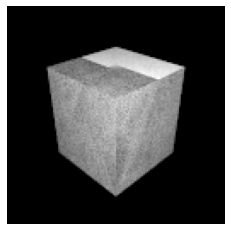

Scene construction, time: 0.16270 s
Forward pass, time: 4.39410 s
8ad01793daeda43dbd71cb387c4297a8


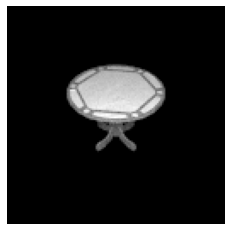

Scene construction, time: 0.04683 s
Forward pass, time: 3.85509 s
b893c20bfb5d718371a782a4379556c7


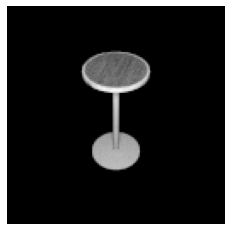

Scene construction, time: 0.89064 s
Forward pass, time: 3.31569 s
e15d98f37565adbe650ec61be62e0cd4


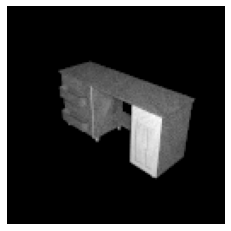

Scene construction, time: 0.09619 s
Forward pass, time: 3.25953 s
9ee005b0d0cf88a0e7e684d25d4dcaf0


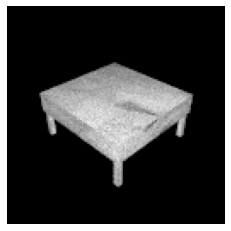

Scene construction, time: 0.37176 s
Forward pass, time: 4.31916 s
ff60e4b29c5cc38fceda3ac62a593e9c


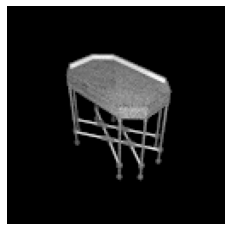

Scene construction, time: 0.11547 s
Forward pass, time: 2.45656 s
1b4e6f9dd22a8c628ef9d976af675b86


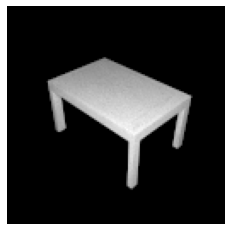

Scene construction, time: 0.95939 s
Forward pass, time: 3.29321 s
25640329444772c6c2e20ec62321c272


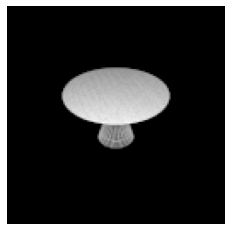

Scene construction, time: 0.04280 s
Forward pass, time: 0.41904 s
370b45eeeb9b11416f04d49e4de95b59


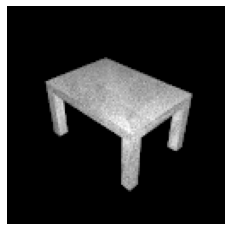

Scene construction, time: 0.05634 s
Forward pass, time: 3.74883 s
93f7c646dc5dcbebbf7421909bb3502


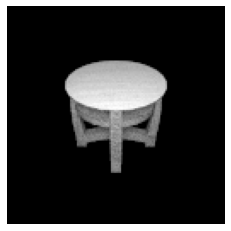

Scene construction, time: 0.38596 s
Forward pass, time: 3.23690 s
2633bba6168a580c8997f7623978b6e4


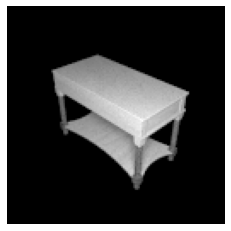

Scene construction, time: 3.15667 s
Forward pass, time: 3.71228 s
15f0878e6bd57e6c417da6e71c86659f


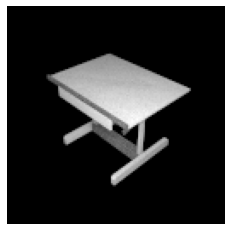

Scene construction, time: 0.28334 s
Forward pass, time: 3.47721 s
927dbeedb2d864d635dda488a4bbb1e1


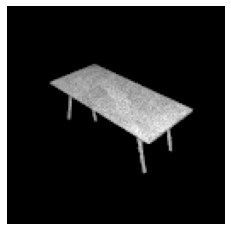

Scene construction, time: 0.42016 s
Forward pass, time: 3.28115 s
4e03170994b4347e6f1e07a56c129dfc


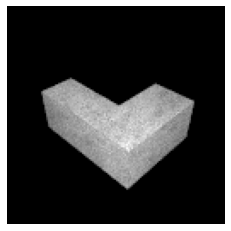

Scene construction, time: 0.09399 s
Forward pass, time: 3.22019 s
580e48297791fb394e684eb336479e2c


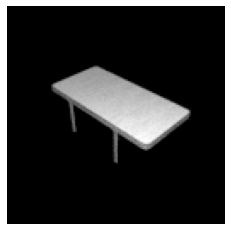

Scene construction, time: 0.04561 s
Forward pass, time: 3.14907 s
1f2fe0bf66eba0b03968da786c4da00c


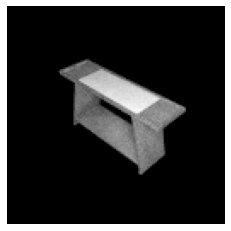

Scene construction, time: 0.39620 s
Forward pass, time: 3.32356 s
43deedd337b00bfcf84b0be7f50940eb


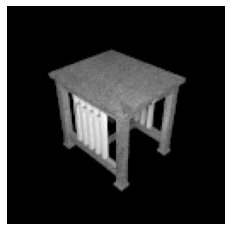

Scene construction, time: 0.29441 s
Forward pass, time: 3.49188 s
c103c0f93c690f5067dc358060e3c47b


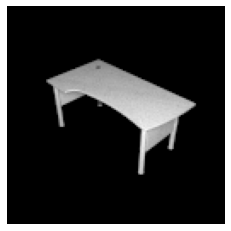

Scene construction, time: 0.24712 s
Forward pass, time: 3.53878 s
23dffe55684018589030b5e29a228aff


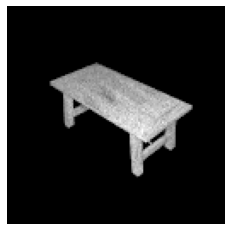

Scene construction, time: 0.02812 s
Forward pass, time: 3.72085 s
4475dea2d05c1ee4fd9792d1e260da32


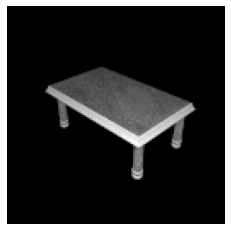

Scene construction, time: 0.16763 s
Forward pass, time: 3.75347 s
db2d4f781756e687d8864caa856253b


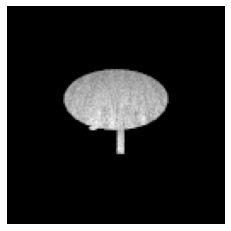

Scene construction, time: 0.44660 s
Forward pass, time: 3.28599 s
745a2b060d0f692bf4b6538438a0b930


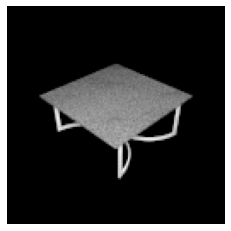

Scene construction, time: 0.11603 s
Forward pass, time: 3.13819 s
48a944dc8751ca7531370540942e6ad


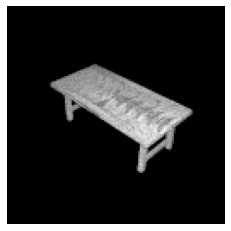

Scene construction, time: 0.38665 s
Forward pass, time: 2.86536 s
a767059df7040b5fbe127423452ccc7b


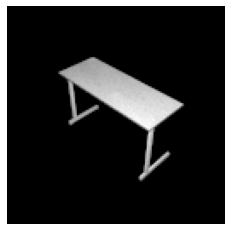

Scene construction, time: 0.09250 s
Forward pass, time: 2.97771 s
9e97c5ba09adfc481b17743c18fb63dc


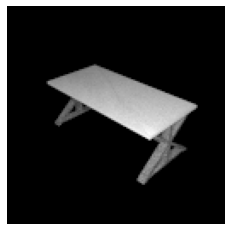

Scene construction, time: 0.14266 s
Forward pass, time: 2.96473 s
adc763e089e2535fdd155b45c76af694


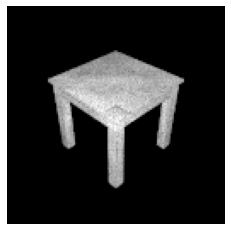

Scene construction, time: 0.24209 s
Forward pass, time: 3.56511 s
1241ec2dc5e59b0ec3bd24f986301745


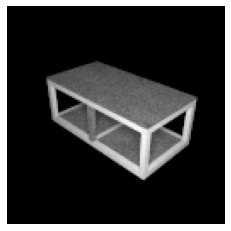

Scene construction, time: 0.51540 s
Forward pass, time: 3.23326 s
623c9a5812ff9ac920768660cf080d12


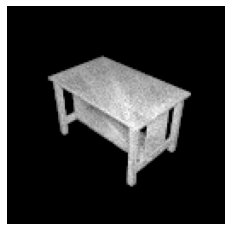

Scene construction, time: 0.27225 s
Forward pass, time: 0.85797 s
bcd046749f03aaab714531f0291497fd


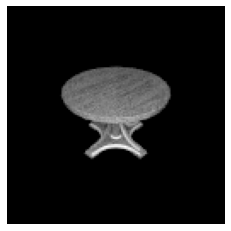

Scene construction, time: 0.22081 s
Forward pass, time: 1.73791 s
b399584ed464f6f5d2bdf2c065ab29bf


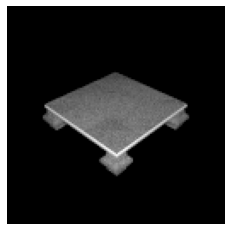

Scene construction, time: 0.64595 s
Forward pass, time: 1.50313 s
cda35fec5923a8602250bf58700b4d8f


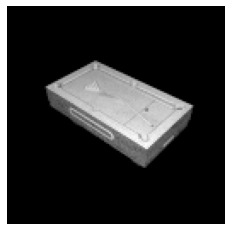

Scene construction, time: 0.68248 s
Forward pass, time: 2.86242 s
f078a5940280c0a22c6c98851414a9d8


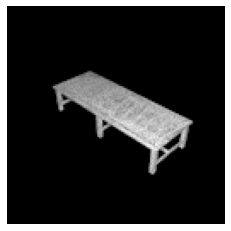

Scene construction, time: 0.23108 s
Forward pass, time: 3.75713 s
f3775c07e5ba9515d6944324b21393b5


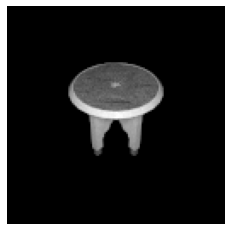

Scene construction, time: 0.60010 s
Forward pass, time: 3.24212 s
cf7c2cfb403f2819548cdb167cc8bdd


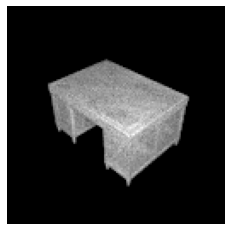

Scene construction, time: 0.09713 s
Forward pass, time: 2.90809 s
e05344d8bd3ef63c5b7bf37141f96eae


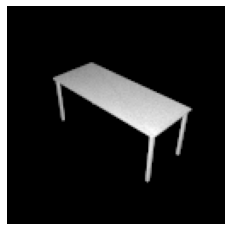

Scene construction, time: 0.21356 s
Forward pass, time: 3.65149 s
546f5dbed1636d097ee0de88f23eac1d


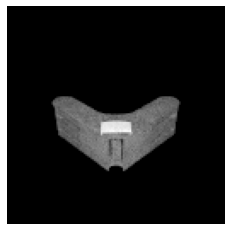

Scene construction, time: 0.07649 s
Forward pass, time: 3.41880 s
7534b0ffb603e3c571a70be9f12ce8b0


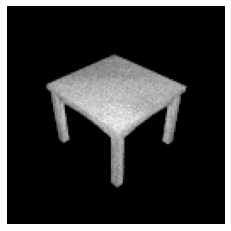

Scene construction, time: 0.03440 s
Forward pass, time: 3.59624 s
91b962b6de5efaad79679c2bd6c2f2c2


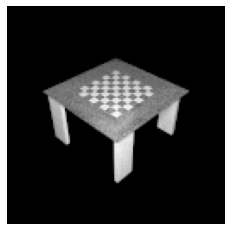

Scene construction, time: 0.28002 s
Forward pass, time: 2.85847 s
aadf84936183c2d7414701ac79f88733


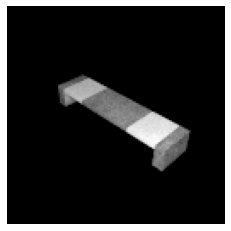

Scene construction, time: 0.17369 s
Forward pass, time: 2.85008 s
acde36e1b4c14b9aec2d07c46434bacd


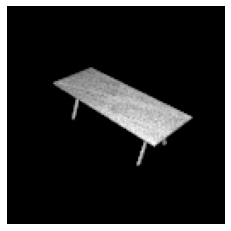

Scene construction, time: 0.03537 s
Forward pass, time: 3.41553 s
a075004f2659de5a797e3338b16ee6ad


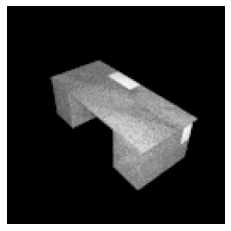

Scene construction, time: 0.03060 s


KeyboardInterrupt: 

In [20]:
for model_file in sampled_per_category_instances['04379243']:
    rendered_im, im_sum = render_shapenet_obj(model_file, scene_cam_pos, scene_light_pos, scene_light_intensity, False)
    plt.imshow(rendered_im)
    print(model_file.split('/')[7])
    plt.axis('off')
    plt.show()
#     except:
#         pass

In [45]:

# cat = 0

# for category in os.listdir(SHAPENET_DIR):  
#     inst = 0
#     category_dir = "%s/%s"%(SHAPENET_DIR, category)
#     instances = os.listdir(category_dir)
#     for instance in instances:
#         instance_dir = "%s/%s"%(category_dir, instance)
#         model_file = "%s/models/model_normalized.obj"%instance_dir
#         randomized_light_pos = torch.tensor([random.uniform(-2,2), random.uniform(-2,2), random.uniform(-2,2)])        
#         rendered_im, im_sum = render_shapenet_obj(model_file, cam_pos, randomized_light_pos, light_intensity, False)
#         image_name = "data/shapenet_rendered/%s_%s_%s_%s_%s.png"%(category, instance, randomized_light_pos[0].item(), randomized_light_pos[1].item(), randomized_light_pos[2].item())
#         rendered_im.save(image_name)
# #         plt.imshow(image_name)
# #         plt.axis('off')
# #         plt.title(randomized_light_pos)
# #         plt.show()
#         inst += 1
#         print("inst: %s"%inst)
#         if inst == 3:
#             break
#     cat += 1
#     print("cat: %s"%cat)
#     if cat == 4:
#         break

Scene construction, time: 0.14220 s
Forward pass, time: 1.24557 s
inst: 1
Scene construction, time: 0.04947 s
Forward pass, time: 1.09627 s
inst: 2
Scene construction, time: 0.01740 s
Forward pass, time: 1.27999 s
inst: 3
cat: 1
Scene construction, time: 0.28368 s
Forward pass, time: 1.30186 s
inst: 1
Scene construction, time: 0.01858 s
Forward pass, time: 1.09382 s
inst: 2
Scene construction, time: 0.31464 s
Forward pass, time: 1.31601 s
inst: 3
cat: 2
Scene construction, time: 0.01279 s
Forward pass, time: 1.35270 s
inst: 1
Scene construction, time: 0.01676 s
Forward pass, time: 1.31843 s
inst: 2
Scene construction, time: 0.01469 s
Forward pass, time: 1.32612 s
inst: 3
cat: 3
Scene construction, time: 0.59704 s
Forward pass, time: 1.58770 s
inst: 1
Scene construction, time: 0.66965 s
Forward pass, time: 1.59996 s
inst: 2
Scene construction, time: 0.08511 s
Forward pass, time: 1.45380 s
inst: 3
cat: 4
